<a href="https://colab.research.google.com/github/ameen7-web/miniprojectML/blob/main/miniprojectML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1-1089003998.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0302 - val_loss: 7.9655e-04
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0013 - val_loss: 7.0735e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 8.6008e-04 - val_loss: 9.7324e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.8069e-04 - val_loss: 0.0019
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 9.4589e-04 - val_loss: 5.5501e-04
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 7.2344e-04 - val_loss: 7.7850e-04
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 8.0363e-04 - val_loss: 5.7286e-04
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 8.9472e-04 - val_loss: 9.4505e-04
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 7.3513e-04 - val_loss: 5.2743e-04
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 6.9359e-04 - val_loss: 6.1746

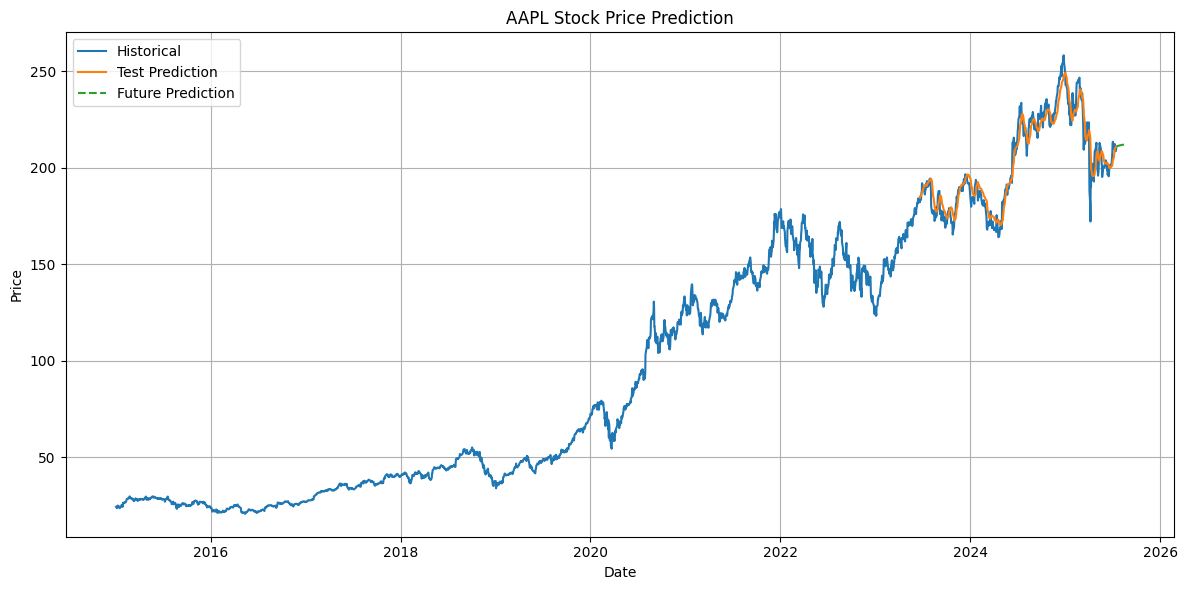

In [1]:
# Simple Stock Prediction with LSTM and Basic Visualization

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta

# --- Parameters ---
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
lookback = 60
future_days = 30

# --- Load Data ---
data = yf.download(ticker, start=start_date, end=end_date)
if data.empty:
    raise ValueError("No data found")

# Only use 'Close' price for simplicity
data = data[['Close']].dropna()

# --- Scale Data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# --- Create Sequences ---
X, y = [], []
for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i - lookback:i])
    y.append(data_scaled[i])
X, y = np.array(X), np.array(y)

# --- Split Data ---
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Build LSTM Model ---
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- Train Model ---
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# --- Predict Test Data ---
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test)

# --- Predict Future ---
last_sequence = data_scaled[-lookback:]
future_predictions = []
for _ in range(future_days):
    pred_input = last_sequence[-lookback:].reshape(1, lookback, 1)
    pred = model.predict(pred_input, verbose=0)[0][0]
    future_predictions.append(pred)
    last_sequence = np.append(last_sequence, [[pred]], axis=0)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
future_dates = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=future_days)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Historical')
plt.plot(data.index[-len(predicted):], predicted, label='Test Prediction')
plt.plot(future_dates, future_predictions, label='Future Prediction', linestyle='--')
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
